In [ ]:
!pip install -q mplfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/IS_Safem0de

 Ensemble_LSTM_and_Candlestick_for_Trading_System.pdf
 EURUSD_H4.csv
'[Prelim]_67130503-Ensemble LSTM and Candlestick for Trading System.pdf'
'Prelim - 67130503.pdf'


In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'

In [ ]:
df = pd.read_csv(data_path)
df.tail()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
25842,2025-10-15 08:00,1.16355,1.16453,1.16195,1.16199,16243
25843,2025-10-15 12:00,1.16201,1.16472,1.16103,1.16369,25939
25844,2025-10-15 16:00,1.16371,1.16448,1.16269,1.16441,14745
25845,2025-10-15 20:00,1.16442,1.16519,1.16418,1.16456,5554
25846,2025-10-16 00:00,1.16455,1.16754,1.16425,1.16659,14450


In [ ]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

df.head()

,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816
2009-10-06 12:00:00,1.47270,1.47612,1.46951,1.47416,15619
2009-10-06 16:00:00,1.47409,1.47537,1.47023,1.47160,13948


In [ ]:
df['body'] = (df['close'] - df['open']).abs()
df['range'] = df['high'] - df['low']
# ป้องกันหารศูนย์
df['range'] = df['range'].replace(0, np.nan)

df['body_ratio']  = df['body'] / df['range']
df['upper_ratio'] = (df['high'] - df[['open','close']].max(axis=1)) / df['range']
df['lower_ratio'] = (df[['open','close']].min(axis=1) - df['low']) / df['range']
df = df.dropna().copy()

สร้าง feature ของแท่งเทียน

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def make_pattern_features(df, window):
    feats, idx = [], []
    for i in range(len(df) - window):
        seg = df.iloc[i:i+window][['body_ratio','upper_ratio','lower_ratio']].values.flatten()
        feats.append(seg)
        idx.append(df.index[i + window - 1])  # ติด label แท่งสุดท้ายของ window
    return np.array(feats), idx

เลือก feature ที่จะ cluster

1 แท่งเทียน

In [ ]:
X1, idx1 = make_pattern_features(df, window=1)
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

k1 = 4
kmeans1 = KMeans(n_clusters=k1, random_state=42)
labels1 = kmeans1.fit_predict(X1_scaled)

df_1candle = df.loc[idx1].copy()
df_1candle['pattern_cluster_1'] = labels1

2 แท่งเทียน

In [ ]:
X2, idx2 = make_pattern_features(df, window=2)
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

k2 = 6
kmeans2 = KMeans(n_clusters=k2, random_state=42)
labels2 = kmeans2.fit_predict(X2_scaled)

df_2candle = df.loc[idx2].copy()
df_2candle['pattern_cluster_2'] = labels2

3 แท่งเทียน

In [ ]:
X3, idx3 = make_pattern_features(df, window=3)
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

k3 = 8
kmeans3 = KMeans(n_clusters=k3, random_state=42)
labels3 = kmeans3.fit_predict(X3_scaled)

df_3candle = df.loc[idx3].copy()
df_3candle['pattern_cluster_3'] = labels3

verify cluster

In [ ]:
# ============================
# 1️⃣ ตรวจ structure ของแต่ละ df
# ============================
print("==== df_1candle ====")
print(df_1candle.head(5))
print(df_1candle.tail(5))
print(f"shape: {df_1candle.shape}")

print("\n==== df_2candle ====")
print(df_2candle.head(5))
print(df_2candle.tail(5))
print(f"shape: {df_2candle.shape}")

print("\n==== df_3candle ====")
print(df_3candle.head(5))
print(df_3candle.tail(5))
print(f"shape: {df_3candle.shape}")


# ============================
# 2️⃣ ตรวจว่า index alignment ถูกหรือไม่
# (index สุดท้ายของ window 2 ต้องขยับ +1 จากต้นฉบับ)
# ============================
print("\nIndex Alignment Check:")
print("df index[0:5] =", df.index[:5])
print("df_2candle index[0:5] =", df_2candle.index[:5])
print("df_3candle index[0:5] =", df_3candle.index[:5])


# ============================
# 3️⃣ ตรวจ cluster distribution
# ============================
print("\nCluster Counts:")
print("1-candle:", df_1candle['pattern_cluster_1'].value_counts().to_dict())
print("2-candle:", df_2candle['pattern_cluster_2'].value_counts().to_dict())
print("3-candle:", df_3candle['pattern_cluster_3'].value_counts().to_dict())


# ============================
# 4️⃣ ตรวจ pattern feature บางส่วน
# ============================
print("\nSample pattern features (2-candle):")
print(df[['body_ratio','upper_ratio','lower_ratio']].head(5))

# ============================
# 5️⃣ ตรวจ pattern feature บางส่วน
# ============================

summary_1 = df_1candle.groupby('pattern_cluster_1')[['body_ratio','upper_ratio','lower_ratio']].mean()
summary_2 = df_2candle.groupby('pattern_cluster_2')[['body_ratio','upper_ratio','lower_ratio']].mean()
summary_3 = df_3candle.groupby('pattern_cluster_3')[['body_ratio','upper_ratio','lower_ratio']].mean()

print("\n==== 1-Candle Mean Shape ====")
print(summary_1.round(3))
print("\n==== 2-Candle Mean Shape ====")
print(summary_2.round(3))
print("\n==== 3-Candle Mean Shape ====")
print(summary_3.round(3))



==== df_1candle ====
                        open     high      low    close  volume     body  \
datetime                                                                   
2009-10-06 00:00:00  1.46563  1.47178  1.46541  1.47035   10300  0.00472   
2009-10-06 04:00:00  1.47051  1.47486  1.46951  1.47169   12566  0.00118   
2009-10-06 08:00:00  1.47176  1.47458  1.47068  1.47264   18816  0.00088   
2009-10-06 12:00:00  1.47270  1.47612  1.46951  1.47416   15619  0.00146   
2009-10-06 16:00:00  1.47409  1.47537  1.47023  1.47160   13948  0.00249   

                       range  body_ratio  upper_ratio  lower_ratio  \
datetime                                                             
2009-10-06 00:00:00  0.00637    0.740973     0.224490     0.034537   
2009-10-06 04:00:00  0.00535    0.220561     0.592523     0.186916   
2009-10-06 08:00:00  0.00390    0.225641     0.497436     0.276923   
2009-10-06 12:00:00  0.00661    0.220877     0.296520     0.482602   
2009-10-06 16:00:00  0.005

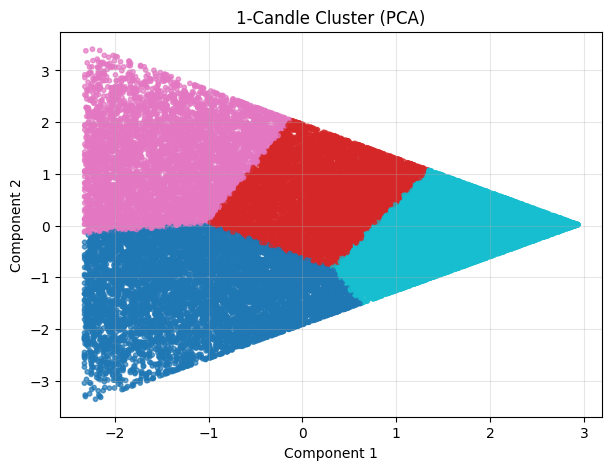

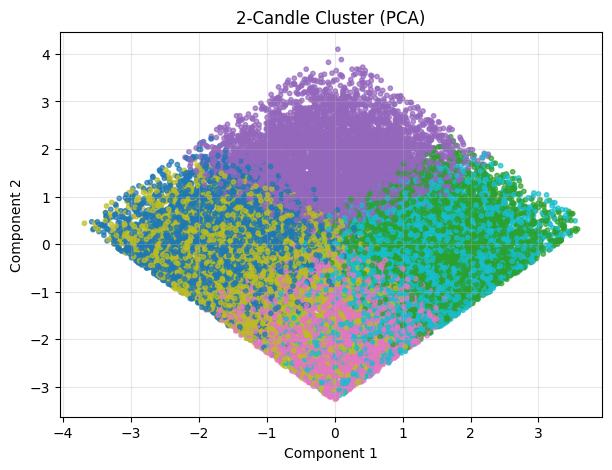

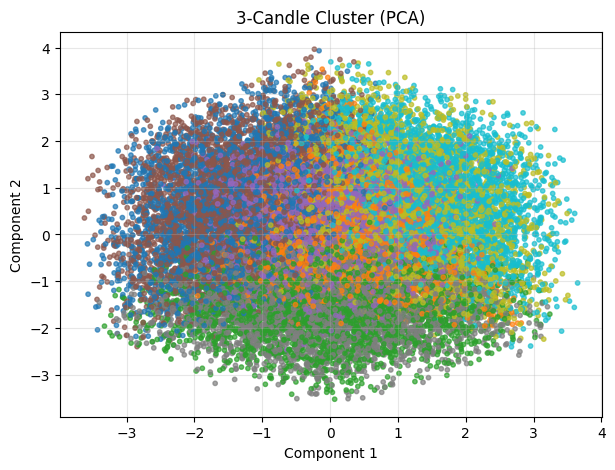

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_cluster_embedding(X_scaled, labels, method='pca', title='Cluster Embedding'):
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        X_emb = reducer.fit_transform(X_scaled)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        X_emb = reducer.fit_transform(X_scaled)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    plt.figure(figsize=(7,5))
    plt.scatter(X_emb[:,0], X_emb[:,1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(alpha=0.3)
    plt.show()

# 🔹 Plot ตรวจสอบแยกกัน
plot_cluster_embedding(X1_scaled, labels1, 'pca', '1-Candle Cluster (PCA)')
plot_cluster_embedding(X2_scaled, labels2, 'pca', '2-Candle Cluster (PCA)')
plot_cluster_embedding(X3_scaled, labels3, 'pca', '3-Candle Cluster (PCA)')


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


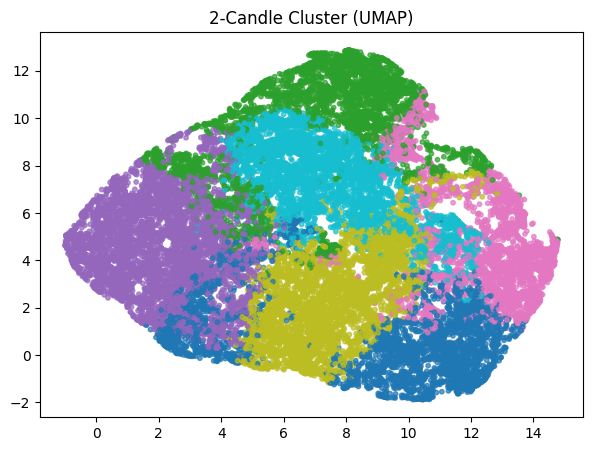

In [ ]:
import umap

reducer = umap.UMAP(random_state=42)
X_emb = reducer.fit_transform(X2_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_emb[:,0], X_emb[:,1], c=labels2, cmap='tab10', s=10, alpha=0.7)
plt.title("2-Candle Cluster (UMAP)")
plt.show()


Elbow Method

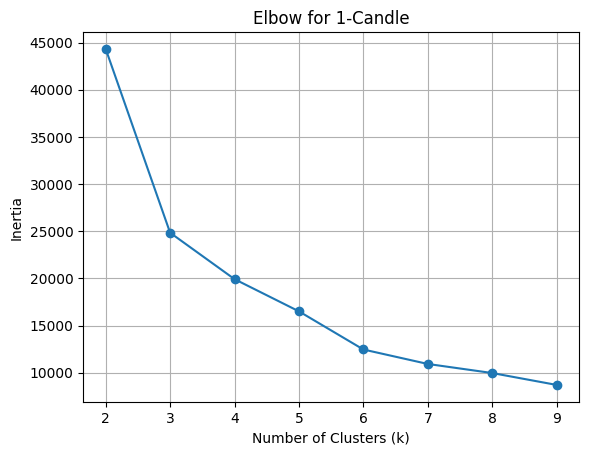

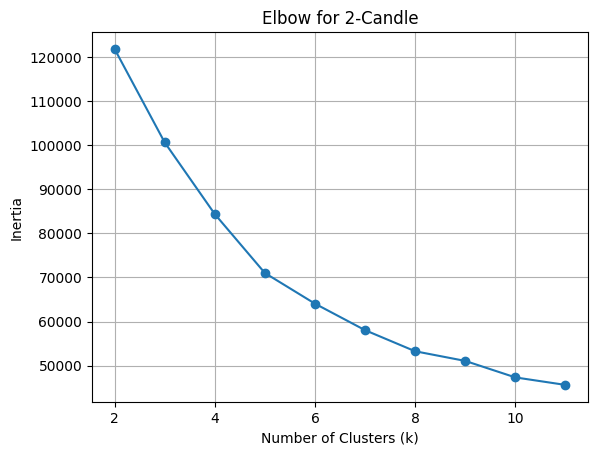

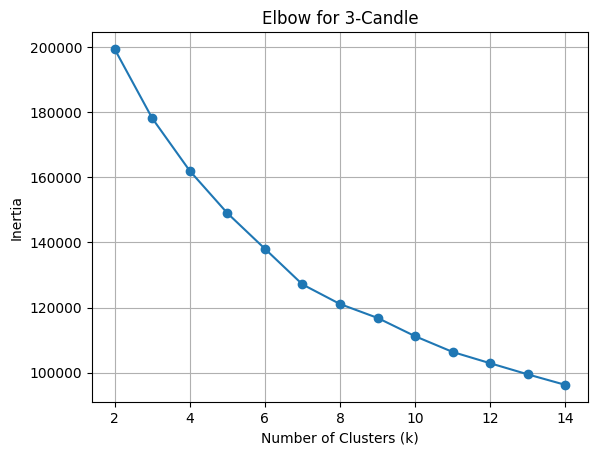

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_elbow(X_scaled, k_range=range(2, 15), title='Elbow Method'):
    inertia = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        inertia.append(km.inertia_)

    plt.plot(k_range, inertia, marker='o')
    plt.title(title)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

# ตัวอย่าง
plot_elbow(X1_scaled, range(2, 10), 'Elbow for 1-Candle')
plot_elbow(X2_scaled, range(2, 12), 'Elbow for 2-Candle')
plot_elbow(X3_scaled, range(2, 15), 'Elbow for 3-Candle')


Silhouette Score (วัดความชัดของ cluster)

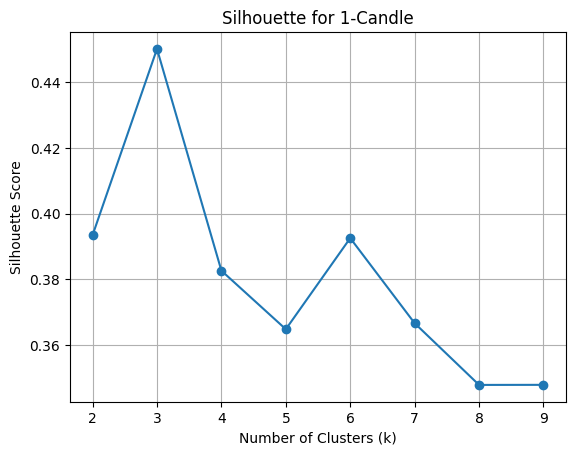

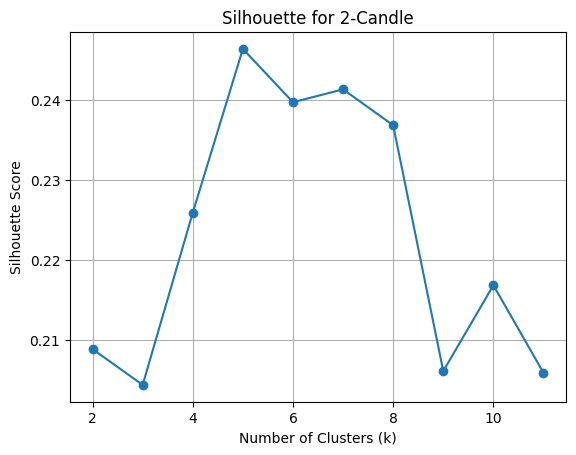

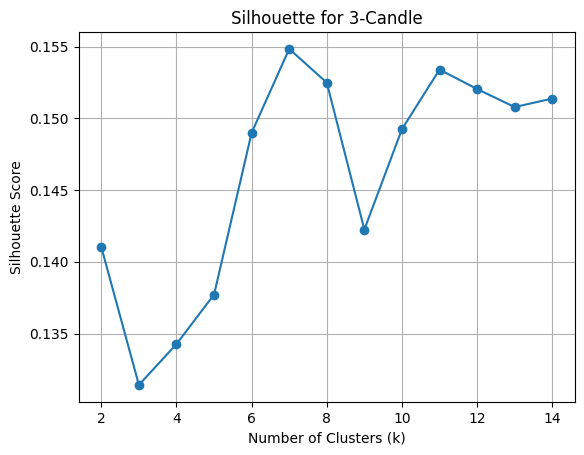

In [ ]:
from sklearn.metrics import silhouette_score

def plot_silhouette(X_scaled, k_range=range(2, 15), title='Silhouette Analysis'):
    scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        scores.append(score)

    plt.plot(k_range, scores, marker='o')
    plt.title(title)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# ตัวอย่าง
plot_silhouette(X1_scaled, range(2, 10), 'Silhouette for 1-Candle')
plot_silhouette(X2_scaled, range(2, 12), 'Silhouette for 2-Candle')
plot_silhouette(X3_scaled, range(2, 15), 'Silhouette for 3-Candle')


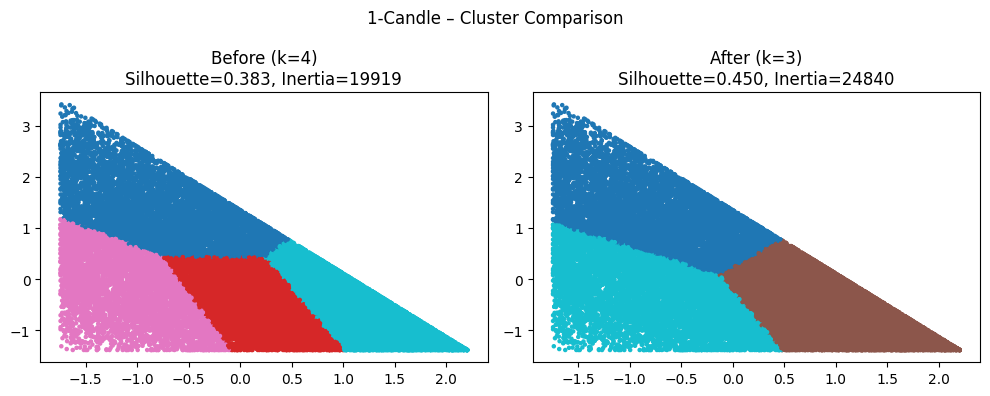

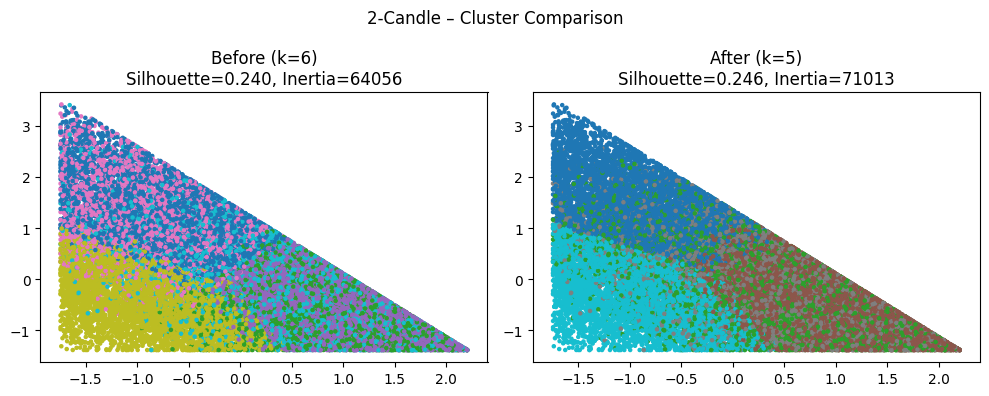

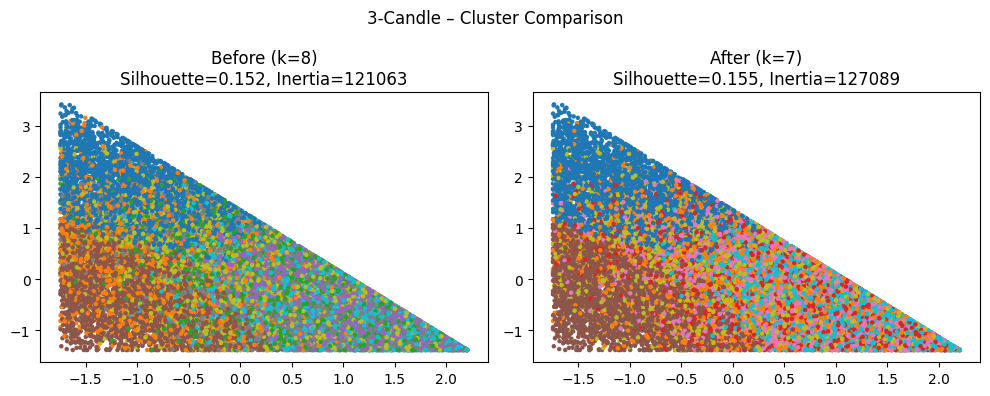

  Version  k  Silhouette        Inertia
0  Before  4    0.382636   19919.417623
1   After  3    0.450127   24839.755514
0  Before  6    0.239757   64055.937583
1   After  5    0.246413   71013.440659
0  Before  8    0.152482  121063.303305
1   After  7    0.154832  127089.176581


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

def compare_kmeans_versions(X_scaled, name, before_k, after_k):
    results = []
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for ax, k, label in zip(axes, [before_k, after_k], ['Before', 'After']):
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(X_scaled)
        s = silhouette_score(X_scaled, labels)
        inertia = km.inertia_
        ax.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap='tab10', s=5)
        ax.set_title(f"{label} (k={k})\nSilhouette={s:.3f}, Inertia={inertia:.0f}")
        results.append({'Version': label, 'k': k, 'Silhouette': s, 'Inertia': inertia})

    plt.suptitle(f"{name} – Cluster Comparison")
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results)

# ตัวอย่างใช้งาน
res_1 = compare_kmeans_versions(X1_scaled, "1-Candle", before_k=4, after_k=3)
res_2 = compare_kmeans_versions(X2_scaled, "2-Candle", before_k=6, after_k=5)
res_3 = compare_kmeans_versions(X3_scaled, "3-Candle", before_k=8, after_k=7)

final_report = pd.concat([res_1, res_2, res_3])
print(final_report)


GMM (k=7) silhouette=0.146


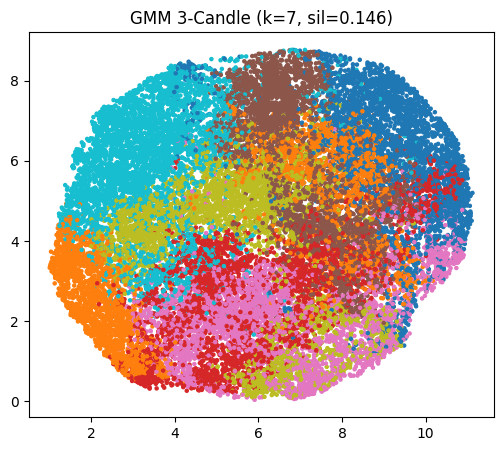

In [ ]:
from sklearn.mixture import GaussianMixture

X = X3_scaled
k = 7

gmm = GaussianMixture(n_components=k, random_state=42)
labels_gmm = gmm.fit_predict(X)
sil = silhouette_score(X, labels_gmm)
print(f"GMM (k={k}) silhouette={sil:.3f}")

X_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_jobs=-1
).fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_gmm, cmap='tab10', s=5)
plt.title(f"GMM 3-Candle (k={k}, sil={sil:.3f})")
plt.show()


In [ ]:
probs = gmm.predict_proba(X)
df_probs = pd.DataFrame(probs, columns=[f"p_cluster_{i}" for i in range(k)])
print(df_probs.head())

   p_cluster_0  p_cluster_1  p_cluster_2  p_cluster_3  p_cluster_4  \
0     0.000032     0.179794     0.002636     0.000001     0.813051   
1     0.580665     0.003852     0.001734     0.000867     0.277635   
2     0.718617     0.001295     0.243324     0.023782     0.006605   
3     0.004500     0.418481     0.006157     0.337913     0.002116   
4     0.002208     0.000005     0.109941     0.002577     0.469014   

   p_cluster_5  p_cluster_6  
0     0.001649     0.002837  
1     0.135199     0.000049  
2     0.003449     0.002927  
3     0.229619     0.001213  
4     0.415235     0.001020  


In [ ]:
print("AIC:", gmm.aic(X))
print("BIC:", gmm.bic(X))

AIC: -448119.5544801835
BIC: -444986.1931808957


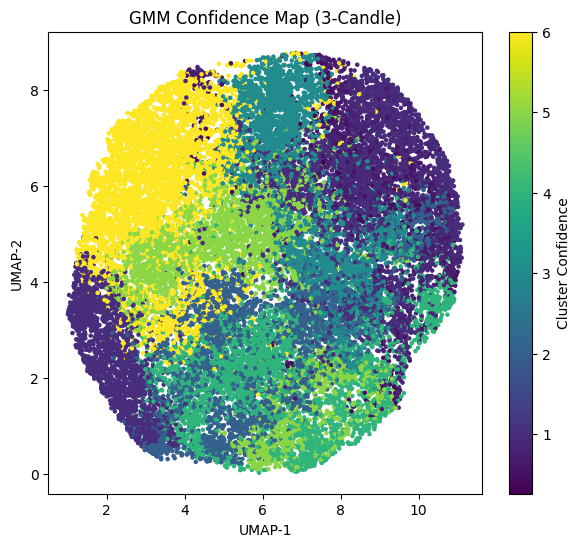

In [ ]:
# แสดงความน่าจะเป็นสูงสุดและความมั่นใจ
df_probs["cluster"] = labels_gmm
df_probs["confidence"] = df_probs.max(axis=1)

plt.figure(figsize=(7,6))
plt.scatter(X_umap[:,0], X_umap[:,1],
            c=df_probs["confidence"], cmap="viridis", s=5)
plt.colorbar(label="Cluster Confidence")
plt.title("GMM Confidence Map (3-Candle)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [ ]:
# ============================================
# 🔹 STEP 1: Compute mean shape for all clusters
# ============================================
summary_1 = df_1candle.groupby('pattern_cluster_1')[['body_ratio','upper_ratio','lower_ratio']].mean()
summary_2 = df_2candle.groupby('pattern_cluster_2')[['body_ratio','upper_ratio','lower_ratio']].mean()
summary_3 = df_3candle.groupby('pattern_cluster_3')[['body_ratio','upper_ratio','lower_ratio']].mean()

In [ ]:
def label_pattern_single(row):
    b = row.get('body_1', row.get('body_ratio', np.nan))
    u = row.get('upper_1', row.get('upper_ratio', np.nan))
    l = row.get('lower_1', row.get('lower_ratio', np.nan))
    if any(pd.isna([b, u, l])):
        return "Unknown"

    b, u, l = float(b), float(u), float(l)

    # --- Doji ---
    if b < 0.12 and u > 0.2 and l > 0.2:
        return "Doji (Neutral)"

    # --- Hammer / Inverted Hammer ---
    if b < 0.35:
        if l > max(u, b) * 1.8:
            return "Hammer (Bullish)"
        if u > max(l, b) * 1.8:
            return "Inverted Hammer (Bullish?)"

    # --- Shooting Star / Hanging Man ---
    if b < 0.35:
        if u > max(l, b) * 1.8 and l < 0.25:
            return "Shooting Star (Bearish)"
        if l > max(u, b) * 1.8 and u < 0.25:
            return "Hanging Man (Bearish)"

    # --- Marubozu ---
    if b > 0.65 and u < 0.20 and l < 0.20:
        return "Marubozu (Strong)"

    # --- Spinning Top (tolerant version) ---
    if 0.15 <= b <= 0.50 and u > 0.15 and l > 0.15:
        return "Spinning Top (Neutral)"

    return "Other"

In [ ]:
def summarize_clusters(X_scaled, labels, window):
    cols = []
    for i in range(window):
        cols += [f'body_{i+1}', f'upper_{i+1}', f'lower_{i+1}']
    df_feat = pd.DataFrame(X_scaled, columns=cols)
    df_feat['cluster'] = labels
    summary = df_feat.groupby('cluster').mean()
    return summary

summary_1 = summarize_clusters(X1, labels1, window=1)
summary_2 = summarize_clusters(X2, labels2, window=2)
summary_3 = summarize_clusters(X3, labels3, window=3)


# ============================================
# 🔹 STEP 2: ใช้ฟังก์ชัน label pattern ที่ปรับแก้แล้ว
# ============================================


def label_pattern_two(row):
    b1, u1, l1 = row['body_1'], row['upper_1'], row['lower_1']
    b2, u2, l2 = row['body_2'], row['upper_2'], row['lower_2']

    if b1 < 0.3 and u1 > 0.5 and b2 > 0.5 and l2 < 0.3:
        return "Bullish Engulfing"
    if b1 < 0.3 and l1 > 0.5 and b2 > 0.5 and u2 < 0.3:
        return "Bearish Engulfing"
    if b1 < 0.3 and b2 < 0.3:
        return "Harami (Indecision)"
    return "Other"


def label_pattern_three(row):
    b1, u1, l1 = row['body_1'], row['upper_1'], row['lower_1']
    b2, u2, l2 = row['body_2'], row['upper_2'], row['lower_2']
    b3, u3, l3 = row['body_3'], row['upper_3'], row['lower_3']

    if b1 > 0.5 and b2 < 0.2 and b3 > 0.5 and l3 < 0.3:
        return "Morning Star (Bullish)"
    if b1 < 0.3 and b2 < 0.2 and b3 > 0.5 and u3 < 0.3:
        return "Evening Star (Bearish)"
    if b1 > 0.4 and b2 > 0.4 and b3 > 0.4:
        return "Three Soldiers (Bullish)"
    return "Other"


def apply_pattern_label(summary_df, window):
    df = summary_df.copy()
    if window == 1:
        df["pattern_name"] = df.apply(label_pattern_single, axis=1)
    elif window == 2:
        df["pattern_name"] = df.apply(label_pattern_two, axis=1)
    elif window == 3:
        df["pattern_name"] = df.apply(label_pattern_three, axis=1)
    return df


# ============================================
# 🔹 STEP 3: Apply & print
# ============================================
summary_1_labeled = apply_pattern_label(summary_1, window=1)
summary_2_labeled = apply_pattern_label(summary_2, window=2)
summary_3_labeled = apply_pattern_label(summary_3, window=3)

print("==== 1-Candle Patterns ====")
print(summary_1_labeled)
print("\n==== 2-Candle Patterns ====")
print(summary_2_labeled)
print("\n==== 3-Candle Patterns ====")
print(summary_3_labeled)

==== 1-Candle Patterns ====
           body_1   upper_1   lower_1                pattern_name
cluster                                                          
0        0.250145  0.561738  0.188116  Inverted Hammer (Bullish?)
1        0.479639  0.181510  0.338852      Spinning Top (Neutral)
2        0.172120  0.231070  0.596810            Hammer (Bullish)
3        0.737141  0.157619  0.105240           Marubozu (Strong)

==== 2-Candle Patterns ====
           body_1   upper_1   lower_1    body_2   upper_2   lower_2  \
cluster                                                               
0        0.244086  0.542446  0.213469  0.655881  0.196374  0.147745   
1        0.649717  0.153919  0.196364  0.239271  0.217118  0.543611   
2        0.673751  0.160082  0.166168  0.672501  0.170906  0.156593   
3        0.217458  0.514583  0.267959  0.218524  0.275534  0.505942   
4        0.220403  0.187966  0.591632  0.510639  0.247689  0.241672   
5        0.525713  0.254387  0.219899  0.220063  0

In [ ]:
# ============================================
# 🔹 STEP 3 (Fixed): Analyze forward return (Bullish/Bearish tendency)
# ============================================

def analyze_returns(base_df, label_col):
    """
    base_df: df_1candle / df_2candle / df_3candle ที่มี cluster label
    label_col: ชื่อคอลัมน์ cluster เช่น 'pattern_cluster_1'
    """
    tmp = base_df[[label_col, 'close']].copy()

    # คำนวณผลตอบแทนของแท่งถัดไป (next candle return)
    tmp['next_close'] = tmp['close'].shift(-1)
    tmp['next_return'] = tmp['next_close'] / tmp['close'] - 1

    # หาค่าเฉลี่ยผลตอบแทนของแต่ละ cluster
    result = tmp.groupby(label_col)['next_return'].mean().to_frame('mean_next_return')
    result['tendency'] = np.where(result['mean_next_return'] > 0, 'Bullish', 'Bearish')
    return result

# ✅ เรียกใช้โดยไม่ join กับ df (เพราะ base_df มี close อยู่แล้ว)
ret_1 = analyze_returns(df_1candle, 'pattern_cluster_1')
ret_2 = analyze_returns(df_2candle, 'pattern_cluster_2')
ret_3 = analyze_returns(df_3candle, 'pattern_cluster_3')


# ============================================
# 🔹 STEP 4: Merge pattern info with return tendency
# ============================================
def merge_summary_and_return(summary_labeled, returns):
    merged = summary_labeled.join(returns, how='left')
    merged = merged.sort_index()
    return merged

final_1 = merge_summary_and_return(summary_1_labeled, ret_1)
final_2 = merge_summary_and_return(summary_2_labeled, ret_2)
final_3 = merge_summary_and_return(summary_3_labeled, ret_3)

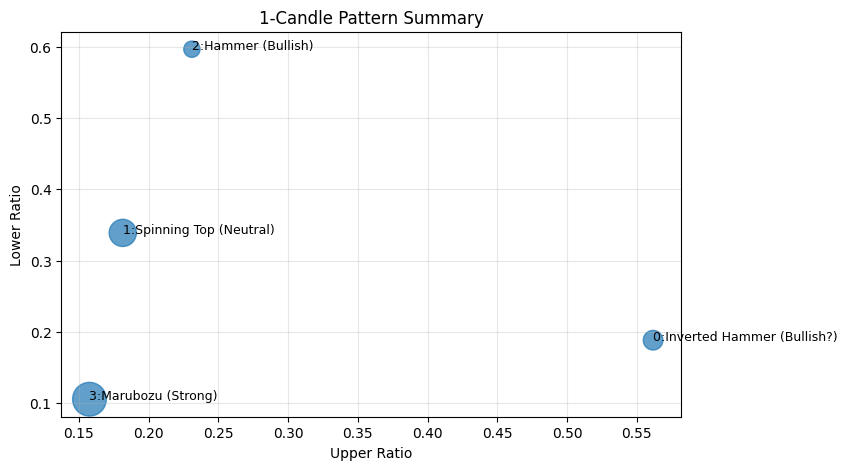

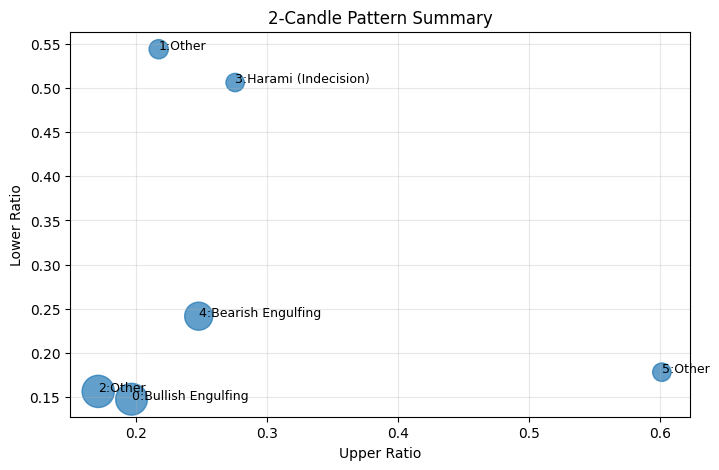

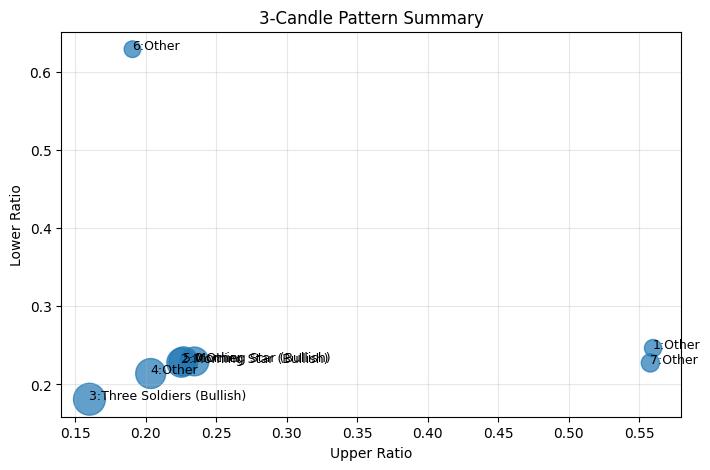

In [ ]:
# ============================================
# 🔹 STEP 5 (Fixed): Visualization summary
# ============================================

def plot_pattern_summary(df_summary, title, window):
    plt.figure(figsize=(8,5))

    # เลือก column ที่จะใช้ plot ตาม window
    if window == 1:
        upper = 'upper_1'; lower = 'lower_1'; body = 'body_1'
    elif window == 2:
        upper = 'upper_2'; lower = 'lower_2'; body = 'body_2'
    else:
        upper = 'upper_3'; lower = 'lower_3'; body = 'body_3'

    plt.scatter(df_summary[upper], df_summary[lower],
                s=df_summary[body]*800, alpha=0.7)

    for i, row in df_summary.iterrows():
        plt.text(row[upper], row[lower], f"{i}:{row['pattern_name']}", fontsize=9)

    plt.title(title)
    plt.xlabel("Upper Ratio")
    plt.ylabel("Lower Ratio")
    plt.grid(alpha=0.3)
    plt.show()

# 🔹 เรียกใช้ใหม่
plot_pattern_summary(final_1, "1-Candle Pattern Summary", window=1)
plot_pattern_summary(final_2, "2-Candle Pattern Summary", window=2)
plot_pattern_summary(final_3, "3-Candle Pattern Summary", window=3)

In [ ]:
# ============================================
# 🔹 STEP 6: Combine & Export result (optional)
# ============================================
final_1['window'] = 1
final_2['window'] = 2
final_3['window'] = 3

final_all = pd.concat([final_1, final_2, final_3])
final_all.to_csv("pattern_summary_all.csv", index=True)

print("\n✅ Exported to 'pattern_summary_all.csv'")
print(final_all)


✅ Exported to 'pattern_summary_all.csv'
           body_1   upper_1   lower_1                pattern_name  \
cluster                                                             
0        0.250145  0.561738  0.188116  Inverted Hammer (Bullish?)   
1        0.479639  0.181510  0.338852      Spinning Top (Neutral)   
2        0.172120  0.231070  0.596810            Hammer (Bullish)   
3        0.737141  0.157619  0.105240           Marubozu (Strong)   
0        0.244086  0.542446  0.213469           Bullish Engulfing   
1        0.649717  0.153919  0.196364                       Other   
2        0.673751  0.160082  0.166168                       Other   
3        0.217458  0.514583  0.267959         Harami (Indecision)   
4        0.220403  0.187966  0.591632           Bearish Engulfing   
5        0.525713  0.254387  0.219899                       Other   
0        0.193612  0.623100  0.183288                       Other   
1        0.244898  0.342109  0.412993                       Ot


🕯️ Cluster 1 (Other) — ตัวอย่าง 5 ชุดแท่ง (2-Candle)


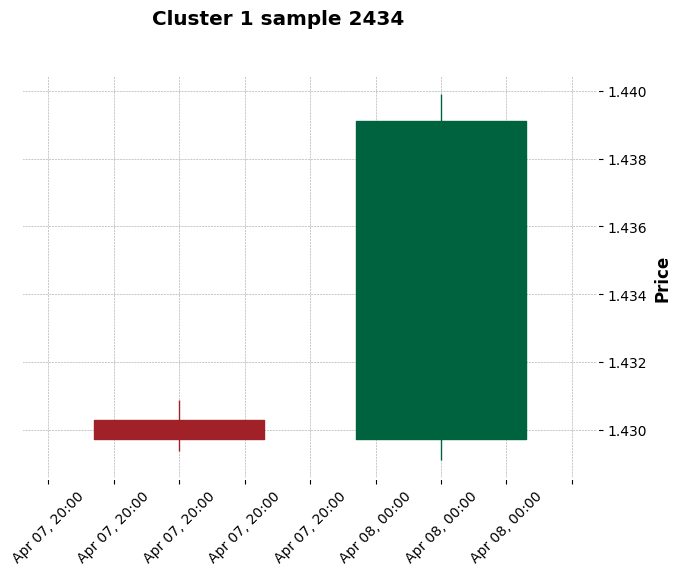

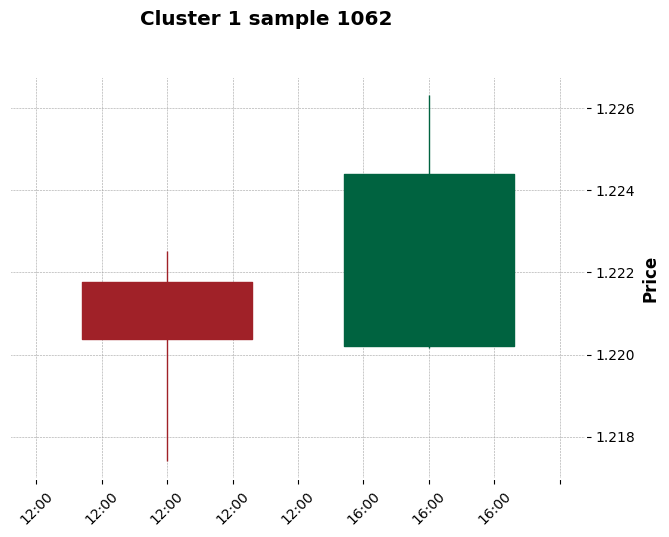

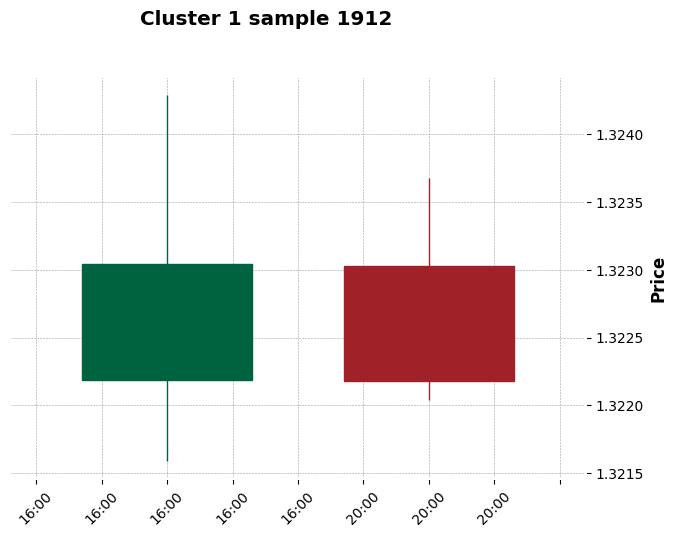

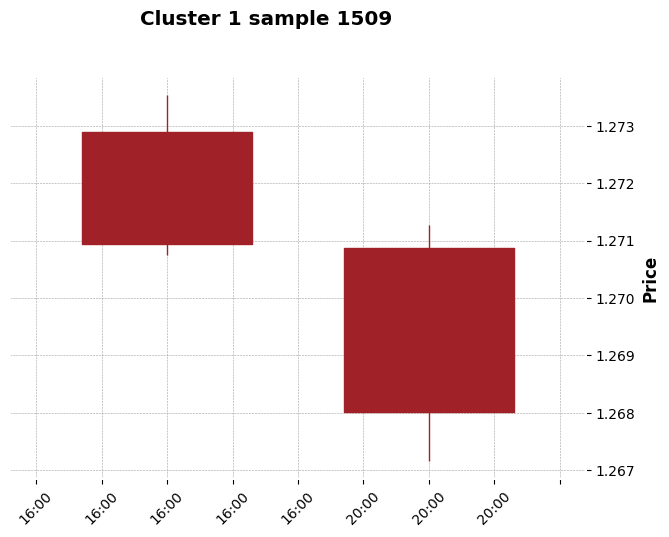

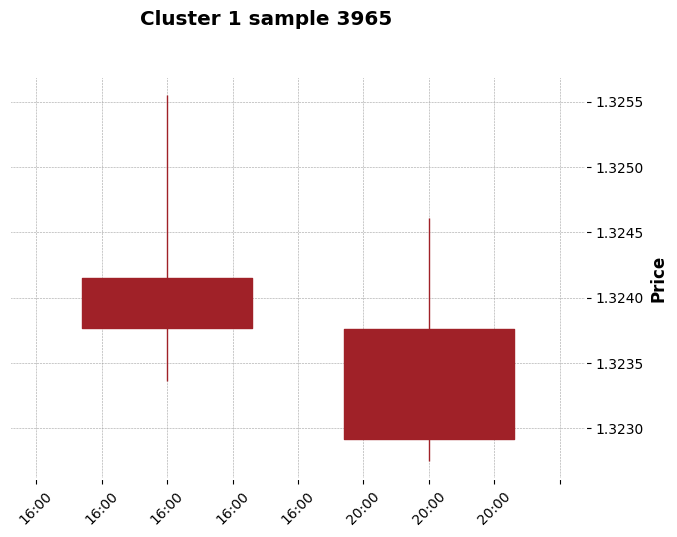


🕯️ Cluster 2 (Other) — ตัวอย่าง 5 ชุดแท่ง (2-Candle)


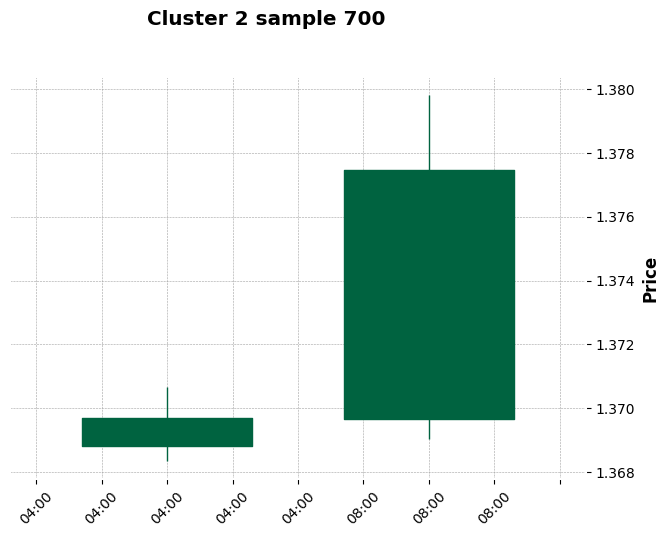

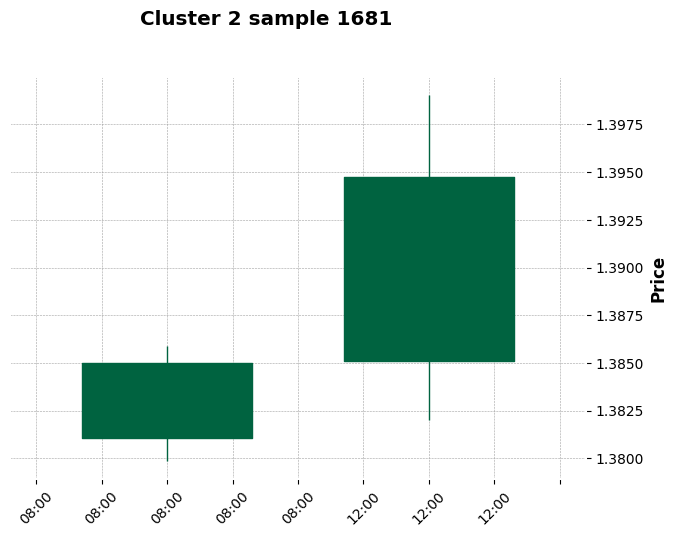

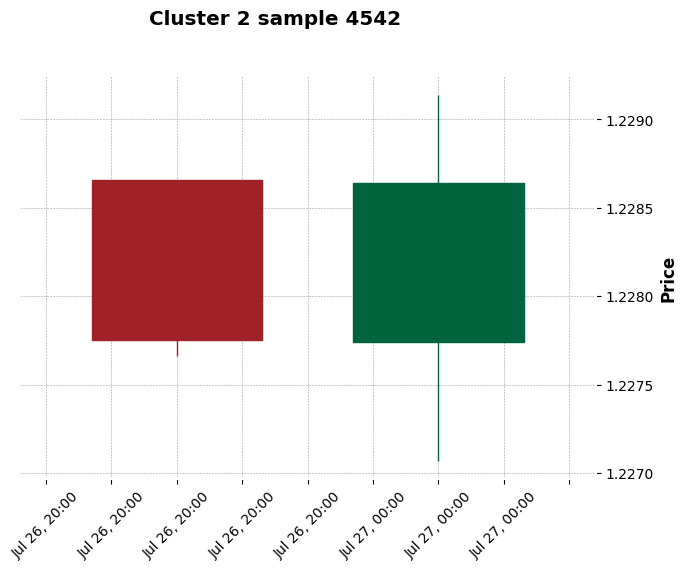

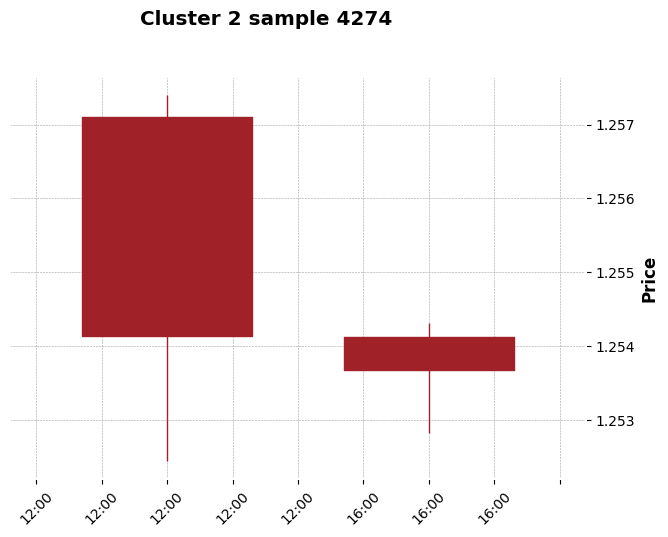

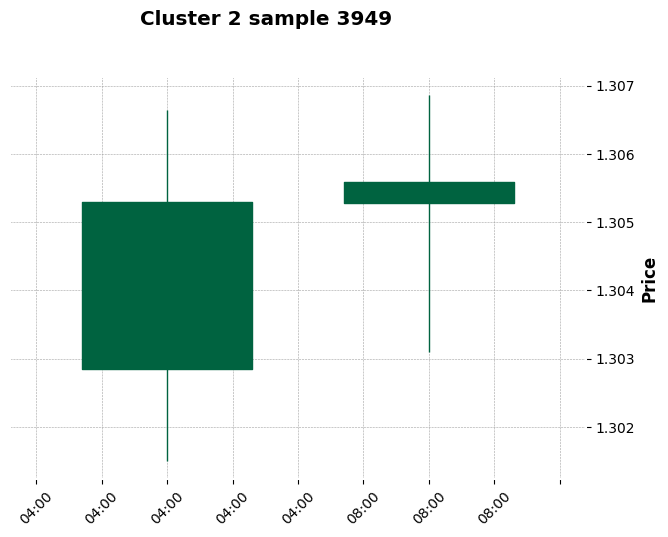


🕯️ Cluster 5 (Other) — ตัวอย่าง 5 ชุดแท่ง (2-Candle)


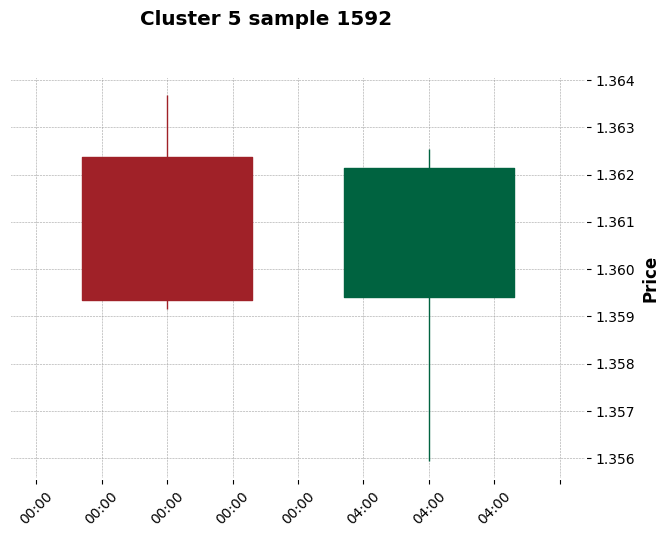

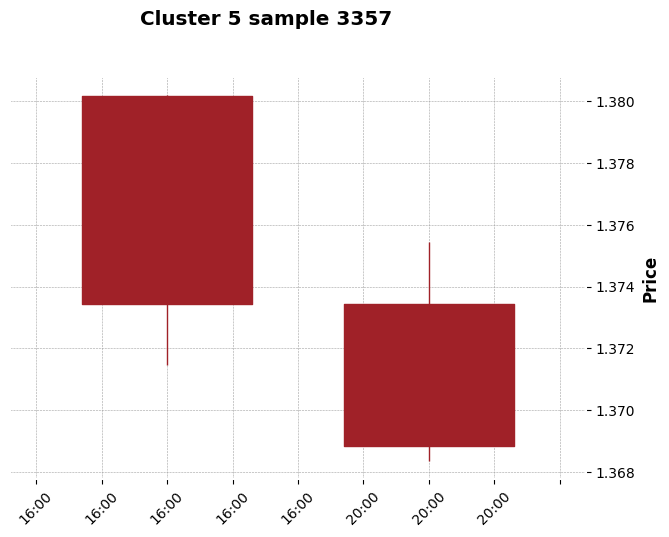

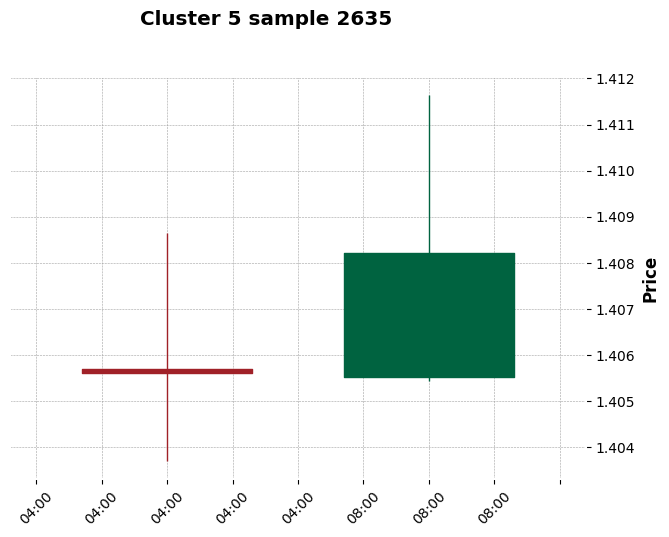

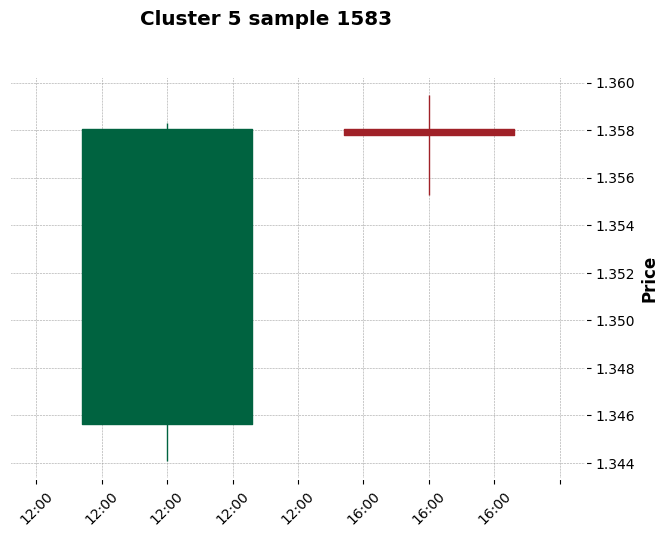

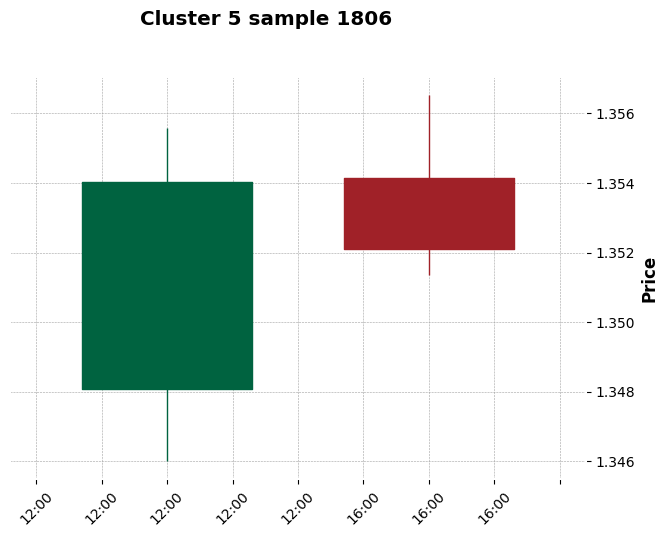

In [ ]:
import random
import mplfinance as mpf

def plot_sample_candles(df_base, cluster_col, summary_labeled, pattern_name="Other", n_sample=5, window=2):
    """
    แสดงแท่งเทียนตัวอย่างจาก pattern_name ที่ต้องการ (เช่น Other)
    รองรับ window 2 หรือ 3 candle
    """
    target_clusters = summary_labeled[summary_labeled["pattern_name"] == pattern_name].index.tolist()
    if not target_clusters:
        print(f"❌ ไม่มี cluster ที่เป็น {pattern_name}")
        return

    for cl in target_clusters:
        print(f"\n🕯️ Cluster {cl} ({pattern_name}) — ตัวอย่าง {n_sample} ชุดแท่ง ({window}-Candle)")
        subset = df_base[df_base[cluster_col] == cl].copy()

        if len(subset) < n_sample:
            n_sample = len(subset)

        # เอา index เป็น list ของตำแหน่งแท่งใน df_base
        sample_pos = random.sample(range(len(subset)), n_sample)

        for pos in sample_pos:
            # ดึงช่วงแท่งจริงจากตำแหน่ง
            start = max(pos, 0)
            end = start + window
            window_df = df_base.iloc[start:end][["open", "high", "low", "close"]]

            if len(window_df) < window:
                continue  # กันแท่งไม่ครบ

            mpf.plot(window_df, type='candle', style='charles',
                     title=f"Cluster {cl} sample {pos}", volume=False)

# 🔹 เรียกใช้
plot_sample_candles(
    df_2candle,
    cluster_col='pattern_cluster_2',
    summary_labeled=summary_2_labeled,
    pattern_name='Other',
    n_sample=5,
    window=2
)